In [1]:
from __future__ import annotations
import sys
sys.path.append('..')  #let me import stuff from the path above

from scipy.stats import poisson
from finite_horizon import *
import pprint

class ClearancePricingMDP:
    initial_inventory: int
    time_steps: int
    price_lambda_pairs: Sequence[Tuple[float,float]]
    single_step_mdp: FiniteMarkovDecisionProcess[int, int]
    mdp: FiniteMarkovDecisionProcess[WithTime[int], int]
    
    def __init__(
        self,
        initial_inventory: int,
        time_steps: int,
        price_lambda_pairs: Sequence[Tuple[float, float]]
    ):
        self.initial_inventory=initial_inventory
        self.price_lambda_pairs=price_lambda_pairs
        self.time_steps=time_steps
        distrs = [ poisson(l) for _, l in price_lambda_pairs]
        prices = [ p for p, _ in price_lambda_pairs]
        self.single_step_mdp: FiniteMarkovDecisionProcess[int, int] = \
            FiniteMarkovDecisionProcess({
                s: {i: Categorical(
                    {(s - k, prices[i] * k):
                     (distrs[i].pmf(k) if k < s else 1 - distrs[i].cdf(s-1))
                     for k in range(s + 1)})
                    for i in range(len(prices))}
                for s in range(initial_inventory + 1)
            })
        self.mdp = finite_horizon_MDP(self.single_step_mdp, time_steps)
        
    def get_vf_for_policy(
        self,
        policy: FintiePolicy[WithTime[int], int]
    )-> Iterator[V[int]]:
        mrp: FiniteMarkovRewardProcess[WithTime[int]] \
            = self.mdp.apply_finite_policy(policy)
        return evaluate(unwrap_finite_horizon_MRP(mrp),1)
    
    def get_optimal_vf_and_policy(self)\
        -> Iterator[Tuple[V[int], FiniteDeterminsticPolicy[int,int]]]:
        return optimal_vf_and_policy(unwrap_finite_horizon_MDP(self.mdp),1)
            

In [6]:
ii = 5 #Number of states
steps = 8
#4 Price choices with respect with mean daily demands
pairs = [(1.0, 0.5), (0.7, 1.0), (0.5, 1.5), (0.3, 2.5)]
cp: ClearancePricingMDP = ClearancePricingMDP(
    initial_inventory=ii,
    time_steps=steps,
    price_lambda_pairs=pairs
)

def policy_func(x: int) -> int:
    return 0 if x < 2 else( 1 if x < 5 else ( 2 if x < 8 else 3))

stationary_policy: FiniteDeterministicPolicy[int, int] =\
    FiniteDeterministicPolicy({s: policy_func(s) for s in range(ii + 1)})
    
single_step_mrp: FiniteMarkovRewardProcess[int] =\
    cp.single_step_mdp.apply_finite_policy(stationary_policy)

vf_for_policy: Iterator[V[int]] = evaluate(
    unwrap_finite_horizon_MRP(finite_horizon_MRP(single_step_mrp, steps)),
    1.
)

optimal_policy = cp.get_optimal_vf_and_policy()

print("Value Function for Stationary Policy")
print("------------------------------------")
for t, vf in enumerate(vf_for_policy):
    print(f"Time Step {t:d}")
    print("---------------")
    # pprint.pprint(vf)
    
print("")
print("Value Function for Optimal Policy")
print("------------------------------------")
for t, vf in enumerate(optimal_policy):
    print(f"Time Step {t:d}")
    print("---------------")
    # pprint.pprint(vf)


Value Function for Stationary Policy
------------------------------------
Time Step 0
---------------
Time Step 1
---------------
Time Step 2
---------------
Time Step 3
---------------
Time Step 4
---------------
Time Step 5
---------------
Time Step 6
---------------
Time Step 7
---------------

Value Function for Optimal Policy
------------------------------------
Time Step 0
---------------
Time Step 1
---------------
Time Step 2
---------------
Time Step 3
---------------
Time Step 4
---------------
Time Step 5
---------------
Time Step 6
---------------
Time Step 7
---------------


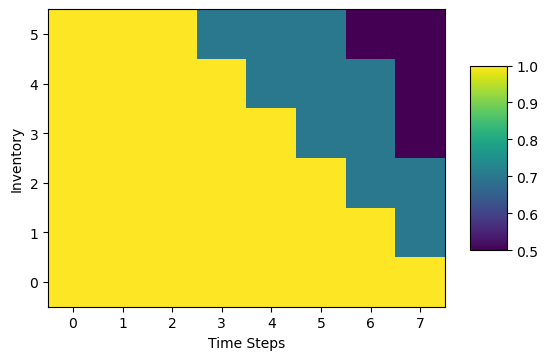

In [7]:
#Do some plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

prices = [[pairs[policy.act(NonTerminal(state=s)).value][0] for s in range(ii + 1)]
        for _, policy in cp.get_optimal_vf_and_policy()]

heatmap = plt.imshow(np.array(prices).T, origin='lower')
plt.colorbar(heatmap,shrink=0.5, aspect=5)
plt.xlabel("Time Steps")
plt.ylabel("Inventory")
plt.show()

# for _, policy in enumerate(cp.get_optimal_vf_and_policy()):
#     print(policy)